In [1]:
import sys
sys.path.append('..')

In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import balanced_accuracy_score, ConfusionMatrixDisplay
import seaborn as sb
import warnings
import numpy as np
import matplotlib.pyplot as plt
from src.utils.metrics import separation_capacity, separation_capacity_tree
warnings.simplefilter(action="ignore")
import plotly.express as px

In [5]:
df_ssim = pd.read_csv(r"/home/chbricout/Downloads/MRART-conv5-motion.csv", index_col=0)
df_motion = pd.read_csv(r"/home/chbricout/Downloads/MRART-conv5_ssim.csv", index_col=0)
merged = pd.merge(df_motion, df_ssim, on=['identifier', 'mode', 'label'], suffixes=("_motion", "_ssim"))

train = merged[merged["mode"] == "train"]
val = merged[merged["mode"] == "val"]

X_train = train[["pred_motion", "pred_ssim"]].to_numpy()
y_train = train["label"].to_numpy()
X_val = val[["pred_motion", "pred_ssim"]].to_numpy()
y_val = val["label"].to_numpy()
px.scatter(merged, x="pred_ssim", y="pred_motion", color="label")

0.6303418803418803


[Text(0.5, 0.875, 'x[0] <= 1.107\ngini = 0.667\nsamples = 258\nvalue = [86.0, 86.0, 86.0]'),
 Text(0.2, 0.625, 'x[1] <= 0.03\ngini = 0.552\nsamples = 140\nvalue = [86.0, 63.759, 10.932]'),
 Text(0.1, 0.375, 'gini = 0.414\nsamples = 70\nvalue = [56.634, 20.759, 1.458]'),
 Text(0.3, 0.375, 'x[1] <= 0.032\ngini = 0.582\nsamples = 70\nvalue = [29.366, 43.0, 9.475]'),
 Text(0.2, 0.125, 'gini = 0.354\nsamples = 10\nvalue = [2.098, 10.379, 0.729]'),
 Text(0.4, 0.125, 'gini = 0.6\nsamples = 60\nvalue = [27.268, 32.621, 8.746]'),
 Text(0.8, 0.625, 'x[0] <= 1.471\ngini = 0.353\nsamples = 118\nvalue = [0.0, 22.241, 75.068]'),
 Text(0.7, 0.375, 'x[1] <= 0.081\ngini = 0.5\nsamples = 44\nvalue = [0.0, 20.759, 21.864]'),
 Text(0.6, 0.125, 'gini = 0.495\nsamples = 42\nvalue = [0.0, 17.793, 21.864]'),
 Text(0.8, 0.125, 'gini = 0.0\nsamples = 2\nvalue = [0.0, 2.966, 0.0]'),
 Text(0.9, 0.375, 'gini = 0.053\nsamples = 74\nvalue = [0.0, 1.483, 53.203]')]

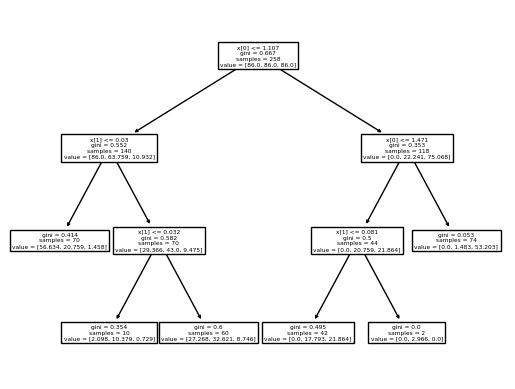

In [49]:

model = DecisionTreeClassifier(
    max_depth=3,
    max_leaf_nodes=6,
    class_weight="balanced",
)
model.fit(X_train, y_train)
accuracy = balanced_accuracy_score(y_val, model.predict(X_val))
print(accuracy)
plot_tree(model)

<Axes: xlabel='label', ylabel='pred'>

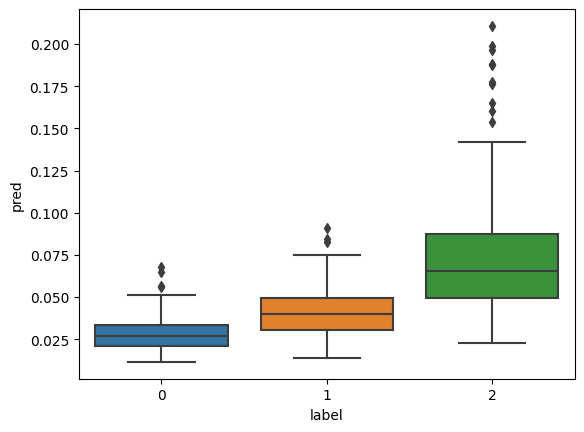

In [50]:
sb.boxplot(df_ssim, x="label", y="pred")

(0.6463675213675214, [0.05677313916385174, 0.03017409984022379])

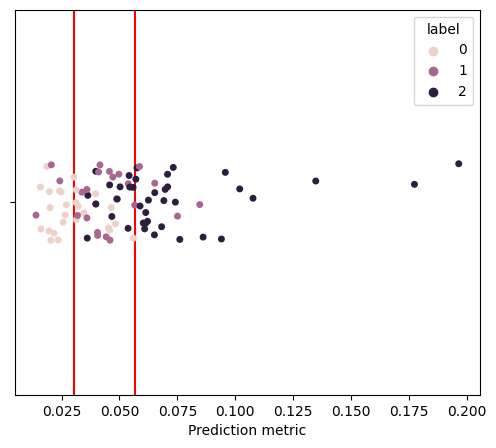

In [51]:
acc, fig, thresh = separation_capacity(df_ssim)
acc, thresh

In [53]:
fig=px.strip(df_ssim, color="label", x="pred", stripmode="overlay", hover_name="identifier")
for t in thresh:
    fig.add_vline(x=t, line_color="red")
fig

## AMPSCZ

,pred,identifier,label,mode
0,0.046488,IR00124_202210141,1.0,train
1,0.044335,IR00124_202212211,1.0,train
2,0.061255,IR00491_202210171,1.0,train
3,0.072617,IR00491_202212191,0.0,train
4,0.075342,IR01451_202210281,1.0,train
...,...,...,...,...
34,0.022934,YA05293_202212051,1.0,val
35,0.074265,YA05293_202209261,0.0,val
36,0.054081,YA16945_202303151,1.0,val
37,0.069575,YA16945_202305241,0.0,val


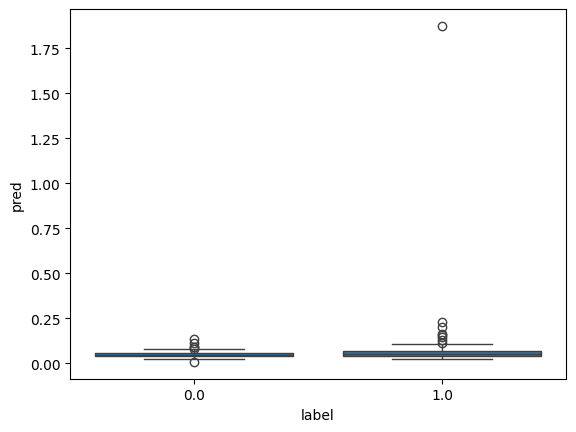

In [6]:
df = pd.read_csv("/home/chbricout/Downloads/AMPSCZ-pred.csv", index_col=0)
sb.boxplot(df, x="label", y="pred")
df

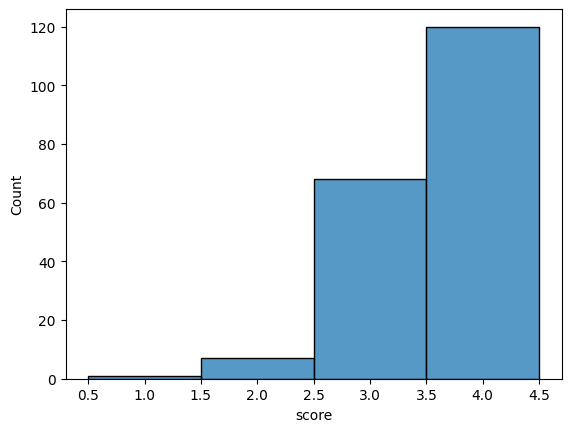

In [21]:
scores = pd.read_csv("/home/chbricout/Master/mrart/src/dataset/ampscz/finetune.csv", index_col=0)
scores['identifier']=scores['sub_id_gs']+'_'+scores['ses_id_gs'].astype(str)
sb.histplot(scores, x="score", discrete=True)
filt_score =scores[['identifier', 'score', 'group']]


In [31]:
score_pred = pd.merge(df, filt_score, on="identifier")
score_pred['label']=score_pred['score']
px.scatter(score_pred, color="score", x='pred', hover_name="identifier")

(np.float64(0.32051282051282054),
 [np.float64(0.14285051822662354),
  np.float64(0.08234754949808121),
  np.float64(0.07862136885523796),
  np.float64(0.023475077003240585)])

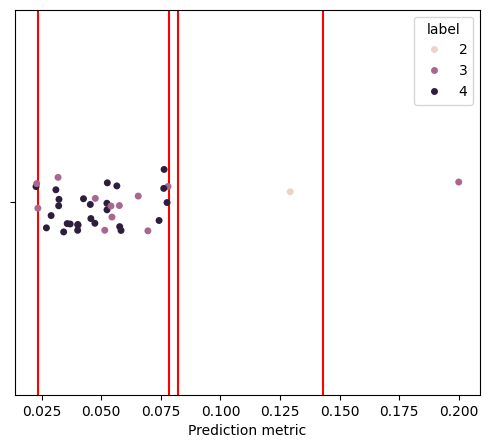

In [30]:
acc, fig, thresh = separation_capacity(score_pred)
acc, thresh                 

(0.0031532703300774, 0.2210890892148017)

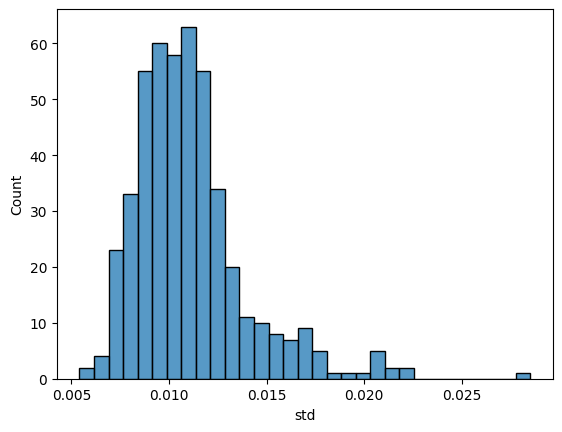

In [139]:
df = pd.read_csv("/home/at70870/Downloads/mcdropout-res.csv", index_col=0)
# sb.boxplot(df, x="label", y="pred")
df['label']=df['label'].astype(float)
sb.histplot(df, x="std")
df['mean'].min(), df['mean'].max()

In [204]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np
df['ls_preds'] = df['predictions'].apply(eval)


def compute_conf(ls):
    arr_preds = np.array([ls])
    binned = np.digitize(arr_preds, bins=np.linspace(0, 0.3,8))
    counted = np.bincount(binned[0])
    return counted.max()/counted.sum()

df['conf'] = df['ls_preds'].apply(compute_conf)
df['conf'].max(), df['conf'].min() 

(1.0, 0.47)

In [205]:
from sklearn.metrics import r2_score


def get_prop_mse_r2(df:pd.DataFrame, conf:float):
    filtered = df[df['conf']>=conf]
    if len(filtered)==0:
        mse=0
        r2=0
    else:
        mse = ((filtered['mean']-filtered['label'])**2).mean()
        r2 = max(r2_score(filtered['label'], filtered['mean']),0)
    filtered_prop = len(filtered)/len(df)
    return mse, r2, filtered_prop

get_prop_mse_r2(df,0)

(0.0003055973899059854, 0.9410446322924488, 1.0)

(0.00022909319082034212,
 0.474468085106383,
 74.96568962543196,
 0.9473993429107166,
 0.7702127659574468,
 99.32924688350067)

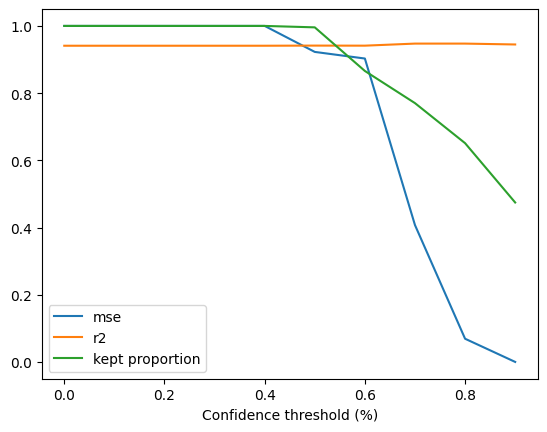

In [224]:
mses = []
r2s = []
props = []
x=np.arange(0,1, 0.1)

for i in x:
    (m,r,p)=get_prop_mse_r2(df, i)
    mses.append(m)
    r2s.append(r)
    props.append(p)

r2s = np.array(r2s)
mses = np.array(mses)
range_t = mses.max() - mses.min()
perc_mses = (mses -mses.min())/range_t

gain = 100*mses.min()/mses.max()
gain_r2 = 100*r2s.min()/r2s.max()

plt.plot(x,perc_mses, label="mse")
plt.plot(x,r2s, label="r2")
plt.plot(x,props, label="kept proportion")
plt.xlabel("Confidence threshold (%)")
# plt.ylim((0.9,1.1))
plt.legend()
np.min(mses), props[np.argmin(mses)], gain, np.max(r2s), props[np.argmax(r2s)], gain_r2, 

In [226]:
get_prop_mse_r2(df,0.8)


(0.00023437248696167015, 0.9473899622296801, 0.6510638297872341)

: 

Text(0.5, 1.0, 'Label against Prediction with 100% confidence')

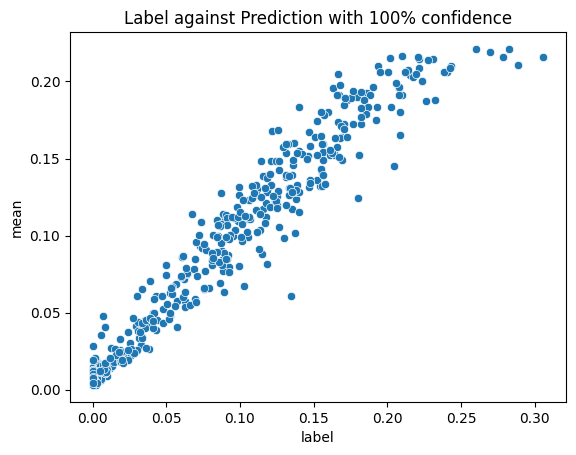

In [216]:
sb.scatterplot(df[df['conf']>=0.5], x="label", y="mean")
plt.title("Label against Prediction with 100% confidence")